In [31]:
import os
import sys
import gzip
import gpxpy
import shutil
import fitdecode
import gpxpy.gpx
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt


from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LinearRegression
from tensorflow.python.framework.random_seed import set_random_seed


if os.getcwd().replace("algorithm_development", "utils") not in sys.path:
    sys.path.append(os.getcwd().replace("algorithm_development", "utils"))


import utils
import parse_fit
import parse_gpx
import parse_tcx

pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


```python
#######################
### UNZIP ALL FILES ###
#######################
strava_export_path = "\\".join(os.getcwd().split("\\")[:-2]) + "\\export_105647830"

for filename in os.listdir(strava_export_path + "\\activities"):
    if filename.endswith('.gz') and filename.replace(".gz", "") not in os.listdir(strava_export_path + "\\activities"): 
        print(filename)
        with gzip.open("\\".join((strava_export_path + "\\activities", filename)), 'rb') as f_in:
            with open("\\".join((strava_export_path + "\\activities", filename))[:-3], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
```

In [2]:
strava_export_path = "\\".join(os.getcwd().split("\\")[:-2]) + "\\export_105647830"

In [3]:
activities_df = pd.read_csv(f"{strava_export_path}\\activities.csv")
activities_df["Filename"] = activities_df["Filename"].apply(lambda v: v.split("/")[1].replace(".gz", "")
                                                            if isinstance(v, str) else v)

In [4]:
list_of_fit_files = ["\\".join((strava_export_path + "\\activities", v)) for v in os.listdir(strava_export_path + "\\activities")
                     if ".gpx" not in v and ".gz" not in v]
list_of_gpx_files = ["\\".join((strava_export_path + "\\activities", v)) for v in os.listdir(strava_export_path + "\\activities")
                     if ".gpx" in v]

```python
##########################################
### GET TO DATAFRAME PER EACH FIT FILE ###
##########################################
list_of_dfs_fit_points = []
list_of_dfs_fit_laps = []
for file in tqdm(list_of_fit_files):
    try:
        d_ = parse_fit.get_dataframes(file)
        list_of_dfs_fit_laps.append(d_[0])
        list_of_dfs_fit_points.append(d_[1])
    except:
        print(file)

fit_file_laps = pd.concat(list_of_dfs_fit_laps, ignore_index = True)
fit_file_points = pd.concat(list_of_dfs_fit_points, ignore_index = True)

fit_file_points = fit_file_points.merge(activities_df, left_on = "FileName", right_on = "Filename", how = "left")
fit_file_points = fit_file_points.drop("compressed_speed_distance", axis = 1)

fit_file_laps = fit_file_laps.merge(activities_df, left_on = "FileName", right_on = "Filename", how = "left")

# SAVE FILES TO AVOID RECOMPUTING EACH TIME
fit_file_laps.to_parquet("{}\\fit_file_laps.parquet".format("\\".join(strava_export_path.split("\\")[:-1]) + "\\data\\"))
fit_file_points.to_parquet("{}\\fit_file_points.parquet".format("\\".join(strava_export_path.split("\\")[:-1]) + "\\data\\"))
```

In [5]:
# SAVE FILES TO AVOID RECOMPUTING EACH TIME
fit_file_laps = pd.read_parquet("{}\\fit_file_laps.parquet".format("\\".join(strava_export_path.split("\\")[:-1] + ["\\data"])))
fit_file_points = pd.read_parquet("{}\\fit_file_points.parquet".format("\\".join(strava_export_path.split("\\")[:-1] + ["\\data"])))

In [8]:
example = utils.slice_parquet_activity(activities_df, fit_file_points, "Granfondo BGY")

In [10]:
avg_power_for_input = [utils.compute_power(weight=85.5, bike_wgt=8.8, speed=5.524, slope=7.097182)
                       for i in range(5000)]
pd.Series(avg_power_for_input).describe()

count    5000.000000
mean        8.376598
std         0.027234
min         8.328902
25%         8.352978
50%         8.376794
75%         8.400342
max         8.423232
dtype: float64

In [13]:
_, dr = parse_fit.get_dataframes("{}\\16438299806_ACTIVITY.fit".format("\\".join(strava_export_path\
                                                                                 .split("\\")[:-1] + ["\\data\\DR"])))

In [75]:
data_scaled = utils.data_cleaning(dr, 85.5, 8.8, True)
data_no_scaling = utils.data_cleaning(dr, 85.5, 8.8, False)

## Model selection

### Non-scaled data
Tried with scaling, it is too unreliable in general. And when it is reliable, increase in models' performance is negligible.

In [76]:
# Linear regression
lr_no_scal = LinearRegression(fit_intercept=True)
lr_no_scal.fit(data_no_scaling["X_train"],
               data_no_scaling["y_train"])

# Random forest
rand_for_no_scal = utils.random_forest_train(data_no_scaling["X_train"],
                                             data_no_scaling["y_train"])

# Neural Net
if 'mlp_no_scal' in locals():
    del mlp_no_scal
mlp_no_scal = Sequential(name = "MLP")
mlp_no_scal.add(Dense(input_dim = 19, units = 19, activation = "relu", name = "dense_1"))
mlp_no_scal.add(Dense(units = 10, activation = "relu", name = "dense_2"))
mlp_no_scal.add(Dense(units = 10, activation = "relu", name = "dense_3"))
mlp_no_scal.add(Dense(units = 1, activation = None, name = "dense_4"))
mlp_no_scal.compile(loss = "mean_absolute_error", optimizer = "adam",
                    metrics = ["mean_absolute_error"])

history_no_scal = mlp_no_scal.fit(
    data_no_scaling["X_train"], data_no_scaling["y_train"],
    epochs = 300, batch_size = 200,
    verbose = 0, validation_split = 0.2,
    callbacks = [
        EarlyStopping(monitor = "mean_absolute_error",
        mode = "min", patience = 20,
        verbose = 1)
    ]
)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[LR_NO_SCAL]
	With ReLU MAE: 0.45 W/kg (38.50 W)
	Without ReLU MAE: 0.48 W/kg (40.72 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 0.24 W/kg (20.71 W)
	Without ReLU MAE: 0.24 W/kg (20.71 W)

[MLP_NO_SCAL]
146/146 [==============================] - 0s 2ms/step
	With ReLU MAE: 0.32 W/kg (27.03 W)
146/146 [==============================] - 0s 2ms/step
	Without ReLU MAE: 0.32 W/kg (27.04 W)

146/146 [==============================] - 0s 2ms/step


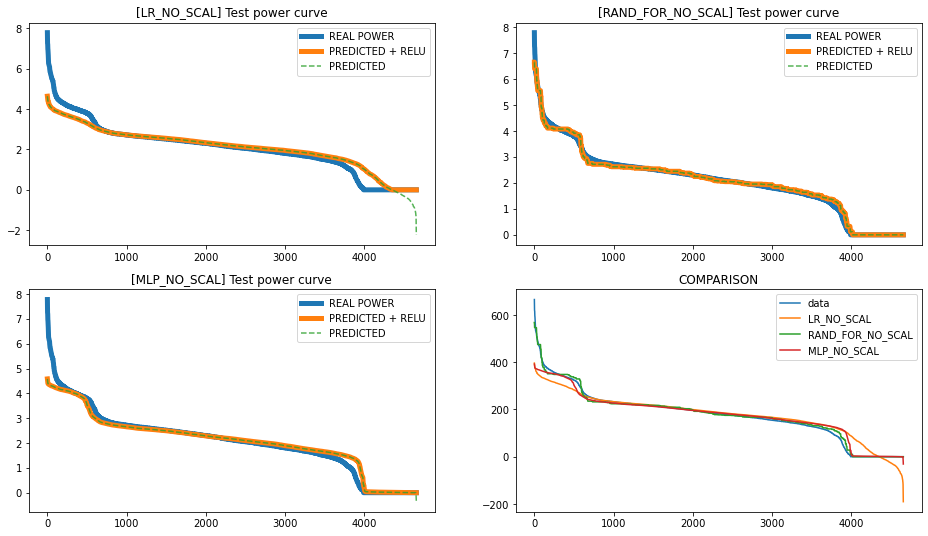

In [77]:
mods_no_scal_dict = {"lr_no_scal": lr_no_scal,
                     "rand_for_no_scal": rand_for_no_scal,
                     "mlp_no_scal": mlp_no_scal}

utils.power_curve_comparison(mods_no_scal_dict, data_no_scaling, 85.5)

[LR_NO_SCAL]
	With ReLU MAE: 0.86 W/kg (73.79 W)
	Without ReLU MAE: 0.86 W/kg (73.84 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 1.10 W/kg (94.07 W)
	Without ReLU MAE: 1.10 W/kg (94.07 W)

[MLP_NO_SCAL]
427/427 [==============================] - 1s 2ms/step
	With ReLU MAE: 0.94 W/kg (80.67 W)
427/427 [==============================] - 1s 2ms/step
	Without ReLU MAE: 0.96 W/kg (81.90 W)

427/427 [==============================] - 1s 2ms/step


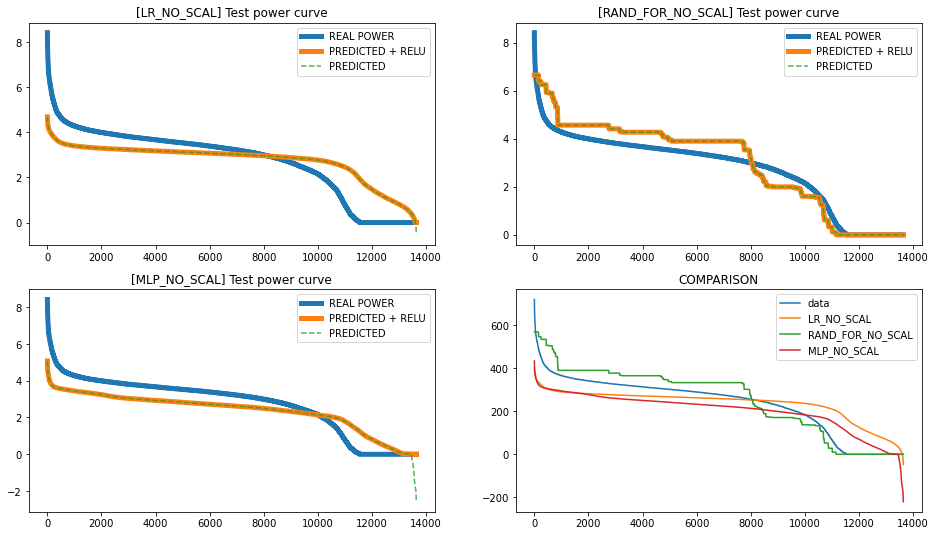

[LR_NO_SCAL]
	With ReLU MAE: 0.45 W/kg (38.76 W)
	Without ReLU MAE: 0.48 W/kg (40.95 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 0.21 W/kg (17.60 W)
	Without ReLU MAE: 0.21 W/kg (17.60 W)

[MLP_NO_SCAL]
486/486 [==============================] - 1s 2ms/step
	With ReLU MAE: 0.31 W/kg (26.79 W)
486/486 [==============================] - 1s 2ms/step
	Without ReLU MAE: 0.31 W/kg (26.81 W)

486/486 [==============================] - 1s 2ms/step


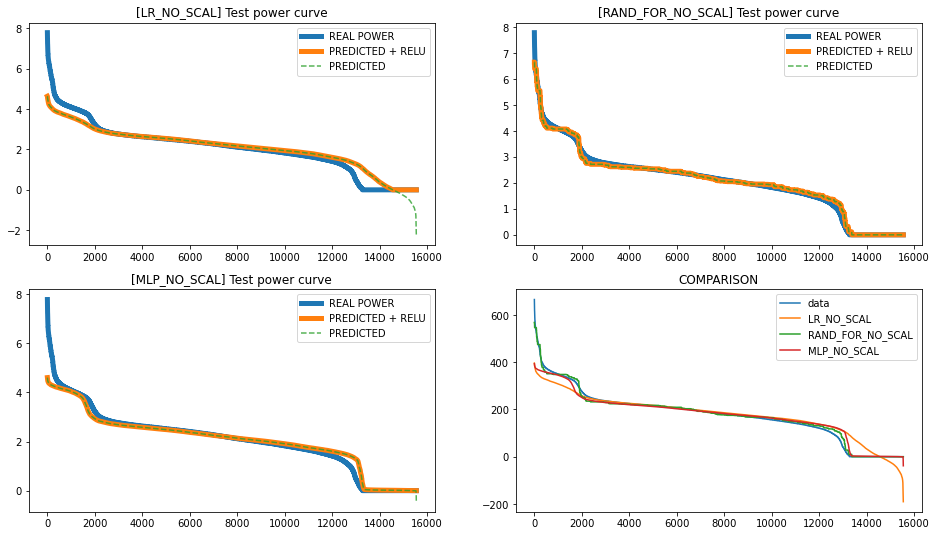

[LR_NO_SCAL]
	With ReLU MAE: 0.63 W/kg (53.74 W)
	Without ReLU MAE: 0.66 W/kg (56.50 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 0.64 W/kg (54.46 W)
	Without ReLU MAE: 0.64 W/kg (54.46 W)

[MLP_NO_SCAL]
476/476 [==============================] - 1s 2ms/step
	With ReLU MAE: 0.56 W/kg (47.52 W)
476/476 [==============================] - 1s 2ms/step
	Without ReLU MAE: 0.56 W/kg (47.57 W)

476/476 [==============================] - 1s 2ms/step


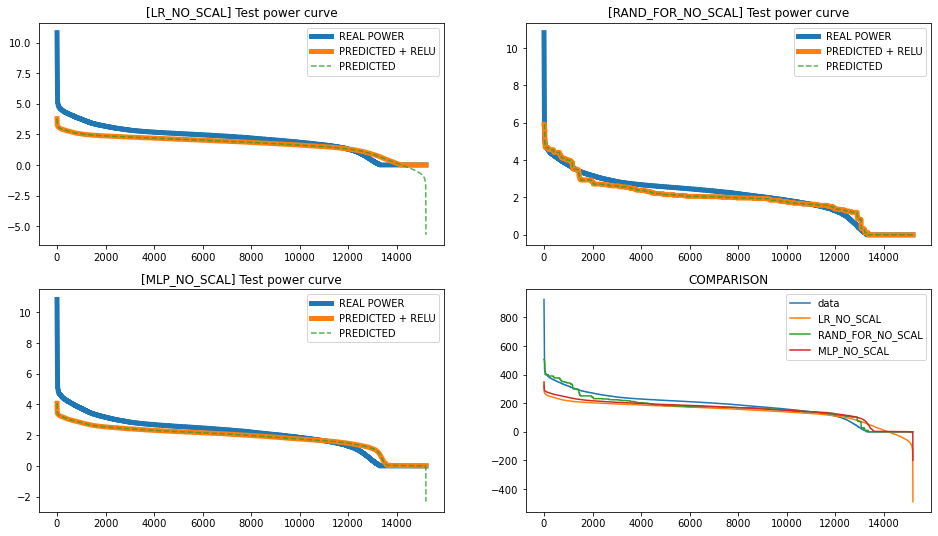

In [78]:
# test on all DR files
for f in os.listdir("\\".join(strava_export_path.split("\\")[:-1] + ["\\data\\DR"])):
    if ".fit" in f:
        _, data = parse_fit.get_dataframes("{}\\{}".format("\\".join(strava_export_path\
                                                                     .split("\\")[:-1] + ["\\data\\DR"]), f ))

        data_dict = utils.data_cleaning(data, weight = 85.5, bike_wgt = 8.8, scaling = False)
        
        data_in = {}
        data_in["X_test"] = pd.concat([data_dict["X_train"], data_dict["X_test"]])
        data_in["y_test"] = pd.concat([data_dict["y_train"], data_dict["y_test"]])
        
        utils.power_curve_comparison(mods_no_scal_dict, data_in, 85.5)
        plt.show()

*** Caldo e vento sugli Euganei🔥🌬 ***
	Zwift avg Watts: 106.10
	[lr_no_scal] avg Watts: 131.46

	Zwift avg Watts: 106.10
	[rand_for_no_scal] avg Watts: 149.29

410/410 [==============================] - 1s 2ms/step
	Zwift avg Watts: 106.10
	[mlp_no_scal] avg Watts: 103.86

[LR_NO_SCAL]
	With ReLU MAE: 1.97 W/kg (131.94 W)
	Without ReLU MAE: 1.98 W/kg (132.41 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 2.23 W/kg (149.29 W)
	Without ReLU MAE: 2.23 W/kg (149.29 W)

[MLP_NO_SCAL]
410/410 [==============================] - 1s 2ms/step
	With ReLU MAE: 1.55 W/kg (103.91 W)
410/410 [==============================] - 1s 2ms/step
	Without ReLU MAE: 1.55 W/kg (103.96 W)

410/410 [==============================] - 1s 2ms/step


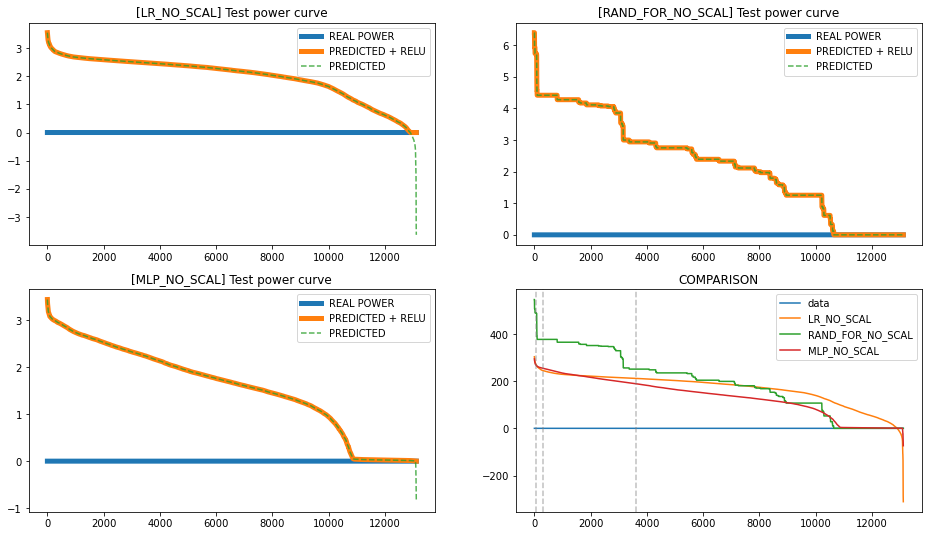

*** A spasso day 2 ***
	Zwift avg Watts: 92.97
	[lr_no_scal] avg Watts: 30.32

	Zwift avg Watts: 92.97
	[rand_for_no_scal] avg Watts: 0.00

2/2 [==============================] - 0s 9ms/step
	Zwift avg Watts: 92.97
	[mlp_no_scal] avg Watts: 11.06

[LR_NO_SCAL]
	With ReLU MAE: 0.99 W/kg (66.63 W)
	Without ReLU MAE: 1.54 W/kg (102.95 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 0.00 W/kg (0.00 W)
	Without ReLU MAE: 0.00 W/kg (0.00 W)

[MLP_NO_SCAL]
2/2 [==============================] - 0s 12ms/step
	With ReLU MAE: 0.17 W/kg (11.14 W)
2/2 [==============================] - 0s 8ms/step
	Without ReLU MAE: 0.17 W/kg (11.23 W)

2/2 [==============================] - 0s 0s/step


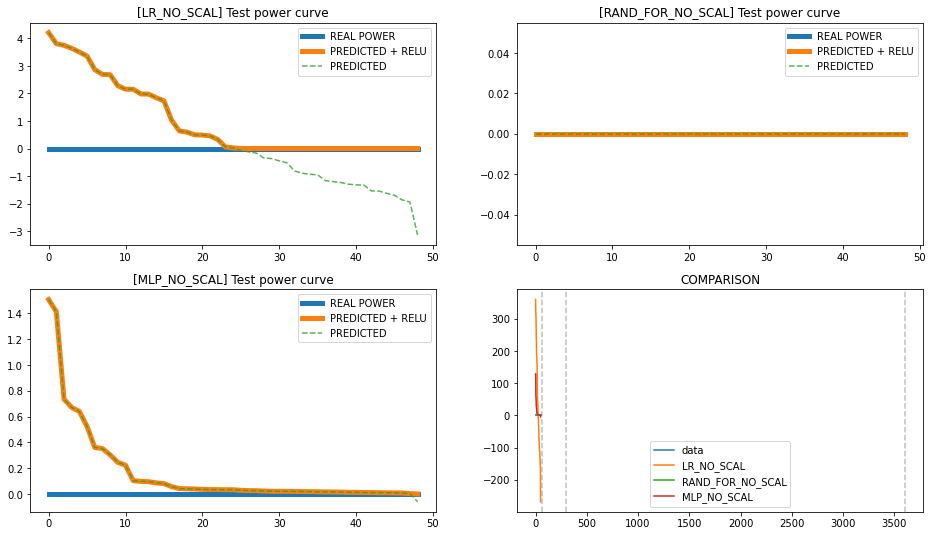

*** Tra pioggia e vento in FVG🌧 ***
	Didn't work

*** Tempo di tornare a casa ***
	Zwift avg Watts: 158.07
	[lr_no_scal] avg Watts: 149.76

	Zwift avg Watts: 158.07
	[rand_for_no_scal] avg Watts: 139.74

95/95 [==============================] - 0s 2ms/step
	Zwift avg Watts: 158.07
	[mlp_no_scal] avg Watts: 162.06

[LR_NO_SCAL]
	With ReLU MAE: 2.25 W/kg (150.61 W)
	Without ReLU MAE: 2.26 W/kg (151.47 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 2.09 W/kg (139.74 W)
	Without ReLU MAE: 2.09 W/kg (139.74 W)

[MLP_NO_SCAL]
95/95 [==============================] - 0s 2ms/step
	With ReLU MAE: 2.42 W/kg (162.06 W)
95/95 [==============================] - 0s 3ms/step
	Without ReLU MAE: 2.42 W/kg (162.07 W)

95/95 [==============================] - 0s 2ms/step


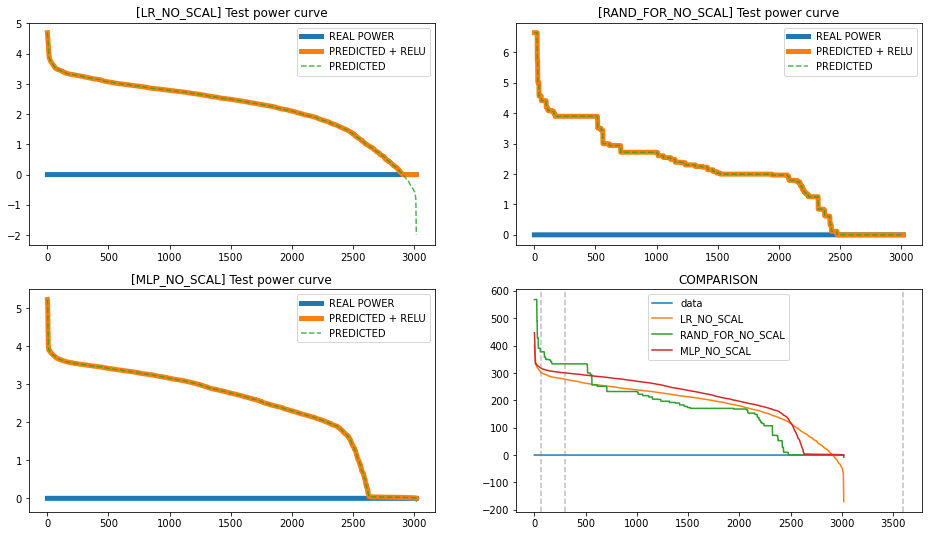

*** Tour De France Stage 1 🟡🟡 ***
	Zwift avg Watts: 130.67
	[lr_no_scal] avg Watts: 135.66

	Zwift avg Watts: 130.67
	[rand_for_no_scal] avg Watts: 142.74

194/194 [==============================] - 0s 2ms/step
	Zwift avg Watts: 130.67
	[mlp_no_scal] avg Watts: 139.04

[LR_NO_SCAL]
	With ReLU MAE: 2.09 W/kg (140.31 W)
	Without ReLU MAE: 2.16 W/kg (144.95 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 2.13 W/kg (142.74 W)
	Without ReLU MAE: 2.13 W/kg (142.74 W)

[MLP_NO_SCAL]
194/194 [==============================] - 0s 2ms/step
	With ReLU MAE: 2.08 W/kg (139.41 W)
194/194 [==============================] - 1s 2ms/step
	Without ReLU MAE: 2.09 W/kg (139.78 W)

194/194 [==============================] - 0s 2ms/step


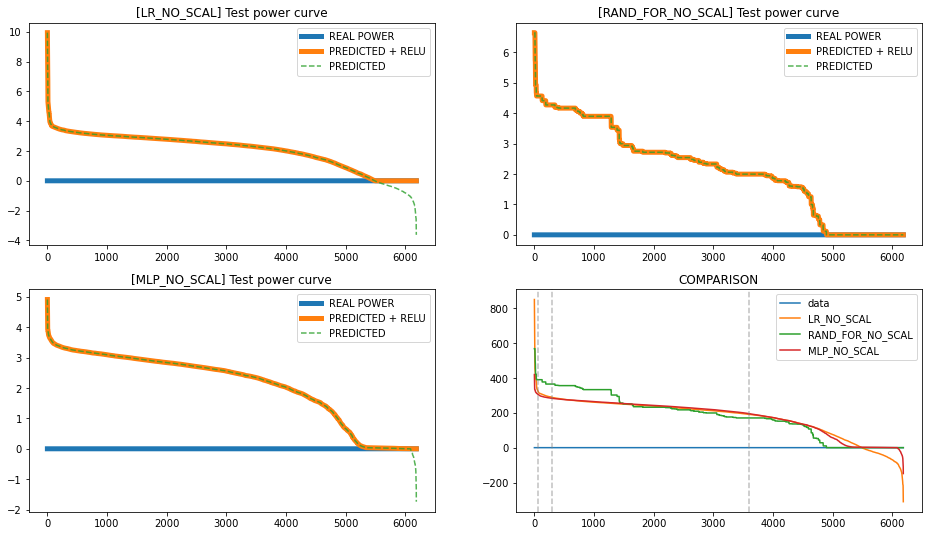

*** Monte Baldo ***
	Zwift avg Watts: 147.60
	[lr_no_scal] avg Watts: 151.84

	Zwift avg Watts: 147.60
	[rand_for_no_scal] avg Watts: 142.36

89/89 [==============================] - 0s 2ms/step
	Zwift avg Watts: 147.60
	[mlp_no_scal] avg Watts: 136.16

[LR_NO_SCAL]
	With ReLU MAE: 2.32 W/kg (155.35 W)
	Without ReLU MAE: 2.37 W/kg (158.86 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 2.12 W/kg (142.36 W)
	Without ReLU MAE: 2.12 W/kg (142.36 W)

[MLP_NO_SCAL]
89/89 [==============================] - 0s 2ms/step
	With ReLU MAE: 2.05 W/kg (137.25 W)
89/89 [==============================] - 0s 2ms/step
	Without ReLU MAE: 2.06 W/kg (138.34 W)

89/89 [==============================] - 0s 2ms/step


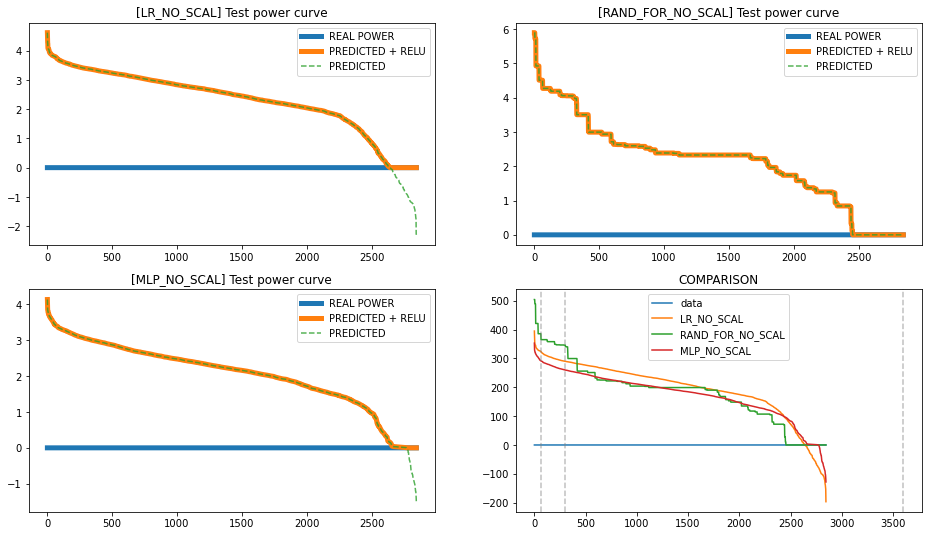

*** Attorno a San Siro prima della UCL ***
	Zwift avg Watts: 115.45
	[lr_no_scal] avg Watts: 162.37

	Zwift avg Watts: 115.45
	[rand_for_no_scal] avg Watts: 117.09

158/158 [==============================] - 0s 2ms/step
	Zwift avg Watts: 115.45
	[mlp_no_scal] avg Watts: 156.78

[LR_NO_SCAL]
	With ReLU MAE: 2.43 W/kg (162.57 W)
	Without ReLU MAE: 2.43 W/kg (162.77 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 1.75 W/kg (117.09 W)
	Without ReLU MAE: 1.75 W/kg (117.09 W)

[MLP_NO_SCAL]
158/158 [==============================] - 0s 2ms/step
	With ReLU MAE: 2.34 W/kg (156.78 W)
158/158 [==============================] - 0s 2ms/step
	Without ReLU MAE: 2.34 W/kg (156.78 W)

158/158 [==============================] - 0s 2ms/step


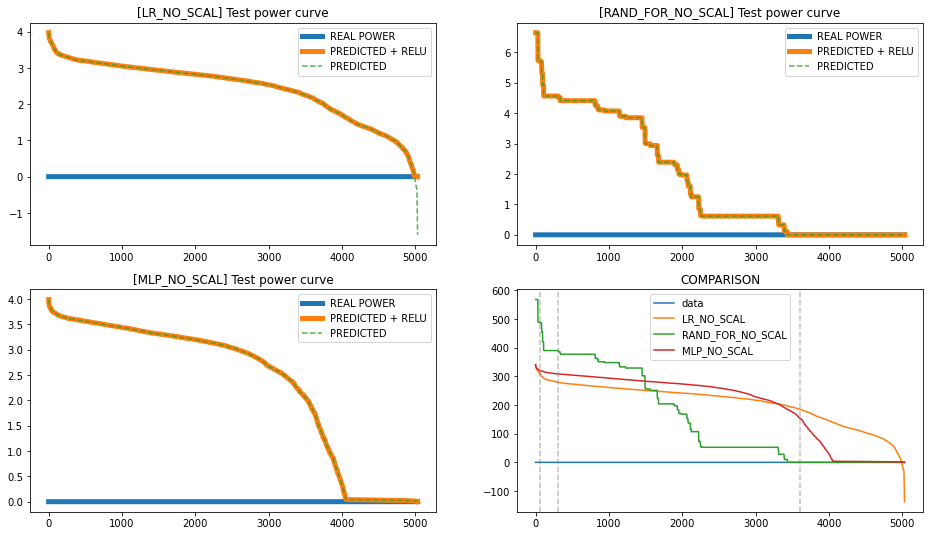

*** Ricognizione GF ILLombardia ***
	Zwift avg Watts: 136.18
	[lr_no_scal] avg Watts: 132.73

	Zwift avg Watts: 136.18
	[rand_for_no_scal] avg Watts: 133.61

263/263 [==============================] - 1s 2ms/step
	Zwift avg Watts: 136.18
	[mlp_no_scal] avg Watts: 141.77

[LR_NO_SCAL]
	With ReLU MAE: 2.08 W/kg (139.03 W)
	Without ReLU MAE: 2.17 W/kg (145.33 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 1.99 W/kg (133.61 W)
	Without ReLU MAE: 1.99 W/kg (133.61 W)

[MLP_NO_SCAL]
263/263 [==============================] - 1s 2ms/step
	With ReLU MAE: 2.13 W/kg (142.82 W)
263/263 [==============================] - 1s 2ms/step
	Without ReLU MAE: 2.15 W/kg (143.87 W)

263/263 [==============================] - 1s 2ms/step


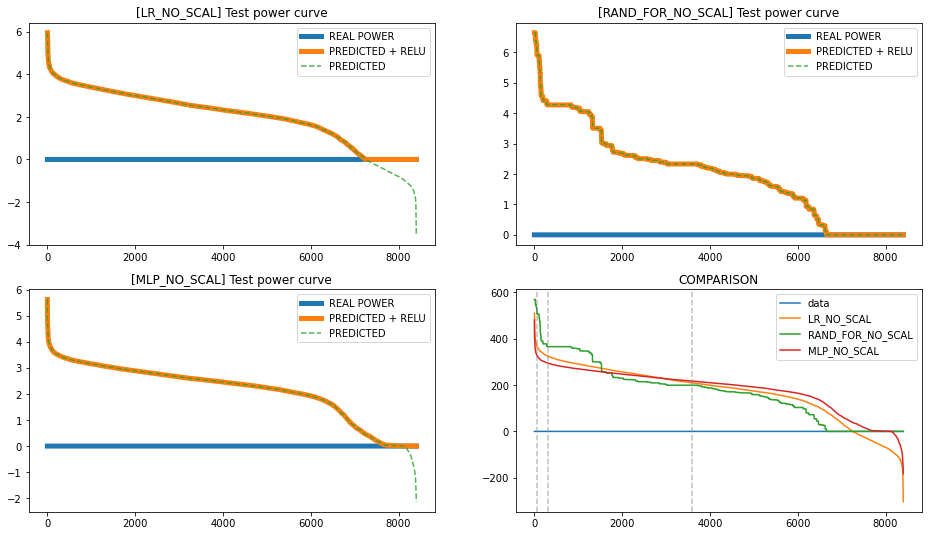

*** GF IlLombardia ***
	Zwift avg Watts: 173.59
	[lr_no_scal] avg Watts: 155.61

	Zwift avg Watts: 173.59
	[rand_for_no_scal] avg Watts: 140.61

235/235 [==============================] - 1s 2ms/step
	Zwift avg Watts: 173.59
	[mlp_no_scal] avg Watts: 154.12

[LR_NO_SCAL]
	With ReLU MAE: 2.37 W/kg (158.70 W)
	Without ReLU MAE: 2.41 W/kg (161.78 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 2.10 W/kg (140.61 W)
	Without ReLU MAE: 2.10 W/kg (140.61 W)

[MLP_NO_SCAL]
235/235 [==============================] - 1s 2ms/step
	With ReLU MAE: 2.32 W/kg (155.31 W)
235/235 [==============================] - 1s 2ms/step
	Without ReLU MAE: 2.34 W/kg (156.51 W)

235/235 [==============================] - 1s 2ms/step


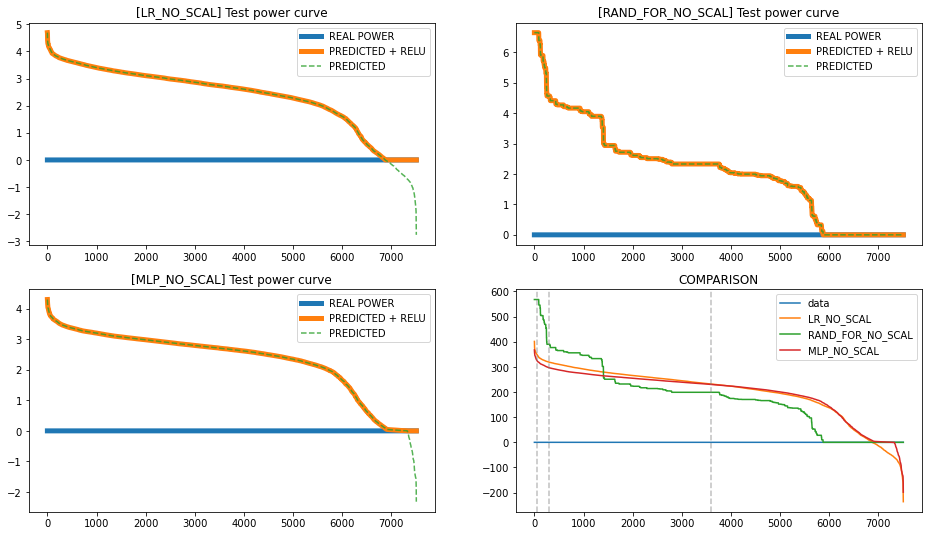

*** Più sfogo che allenamento ***
	Zwift avg Watts: 120.94
	[lr_no_scal] avg Watts: 125.65

	Zwift avg Watts: 120.94
	[rand_for_no_scal] avg Watts: 117.90

76/76 [==============================] - 0s 2ms/step
	Zwift avg Watts: 120.94
	[mlp_no_scal] avg Watts: 126.92

[LR_NO_SCAL]
	With ReLU MAE: 1.92 W/kg (128.31 W)
	Without ReLU MAE: 1.95 W/kg (130.96 W)

[RAND_FOR_NO_SCAL]
	With ReLU MAE: 1.76 W/kg (117.90 W)
	Without ReLU MAE: 1.76 W/kg (117.90 W)

[MLP_NO_SCAL]
76/76 [==============================] - 0s 2ms/step
	With ReLU MAE: 1.90 W/kg (126.99 W)
76/76 [==============================] - 0s 2ms/step
	Without ReLU MAE: 1.90 W/kg (127.06 W)

76/76 [==============================] - 0s 2ms/step


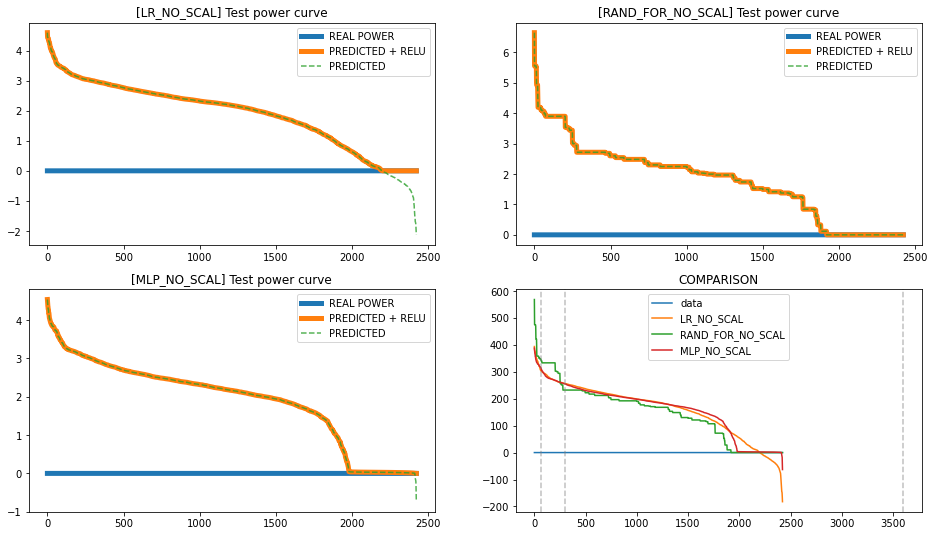

In [86]:
# test on some of my FIT files
sample_activities = activities_df[~(activities_df["Activity Name"].str.contains("Zwift")) &
                                  (activities_df["Average Watts"].notna()) &
                                  (activities_df["Average Heart Rate"].notna())]["Activity Name"].sample(10)


for a in sample_activities:
    print(f"*** {a} ***")
    
    input_data = utils.slice_parquet_activity(zwift_data = activities_df,
                                              parquet_data = fit_file_points,
                                              activity_name = a,
                                              col_subset = False)
    if len(input_data) > 0:
        _data_dict = utils.data_cleaning(input_data, weight = 67, bike_wgt = 9.8, scaling = False)
        _data_in = {}
        _data_in["X_test"] = pd.concat([_data_dict["X_train"], _data_dict["X_test"]])
        _data_in["y_test"] = pd.concat([_data_dict["y_train"], _data_dict["y_test"]])

        recording_interval = input_data["timestamp"].diff().dropna().min().seconds
        if _data_dict["X_train"].isnull().sum().sum() == 0:
            
            for n,m in mods_no_scal_dict.items():
                prediction = m.predict(pd.concat([_data_dict["X_train"], _data_dict["X_test"]],
                                                 ignore_index = True))
                print("\tZwift avg Watts: {:.2f}".format(input_data["Average Watts"].max()))
                print("\t[{}] avg Watts: {:.2f}".format(n, 67 * prediction.mean()))
                print()
#             plt.figure(figsize = (16, 5))
#             plt.plot(sorted(prediction, reverse=True), label = "PREDICTED")
            utils.power_curve_comparison(mods_no_scal_dict, _data_in, 67)
            plt.axvline(60 / recording_interval, color = "grey", alpha = .5, ls = "--")
            plt.axvline(300 / recording_interval, color = "grey", alpha = .5, ls = "--")
            plt.axvline(3600 / recording_interval, color = "grey", alpha = .5, ls = "--")
            #plt.xlim(-20, len(X_input) * 1.1)
            #plt.xscale("log")
            plt.legend()
            plt.show()
    else:
        print("\tDidn't work")
        print()

In [ ]:
def predict_from_mlp(input_data, weights, biases):
    """
    Perform predictions from scratch using a neural network model.

    Parameters:
    - input_data: A numpy array of shape (n_samples, n_features)
    - weights: A list of numpy arrays, each representing the weights for a dense layer
    - biases: A list of numpy arrays, each representing the biases for a dense layer

    Returns:
    - predictions: The output of the model for each sample
    """
    
    # Forward pass through each layer
    layer_output = input_data
    for i in range(len(weights) - 1):  # Apply ReLU for all but the last layer
        layer_output = ReLU(np.dot(layer_output, weights[i]) + biases[i])

    # Final layer (without activation for output layer)
    output = np.dot(layer_output, weights[-1]) + biases[-1]
    
    return output

In [ ]:
print("Real: {:.4f} | Predictions: {:.4f}".format(y_test.iloc[10],
                                                  predict_from_mlp(input_data = X_test.iloc[10].values,
                                                                   weights = [np.array(neural_Net.weights[i])
                                                                              for i in np.arange(0, 8, 2)],
                                                                   biases = [np.array(neural_Net.weights[i])
                                                                             for i in np.arange(1, 8, 2)])[0])
     )

In [ ]:
def predict_from_tree(tree, instance):
    node = 0  # start from the root
    while tree.children_left[node] != -1:  # while not a leaf
        feature_index = tree.feature[node]
        threshold = tree.threshold[node]
        
        if instance.iloc[feature_index] <= threshold:
            node = tree.children_left[node]
        else:
            node = tree.children_right[node]
    
    # When a leaf is reached
    return tree.value[node][0, 0]

# Example usage
instance = dr_X_test.iloc[100]  # An instance to predict
prediction = predict_from_tree(model.tree_, instance)
print(f"Predicted value: {prediction:.2f} W/kg ({prediction * 85.5:.0f} W)")